In [29]:
%reload_ext autoreload
%autoreload 2

In [30]:
from database_io.db_handler import DB_handler
import pymc as pm
import numpy as np
import pandas as pd

import plotly.express as px

In [31]:
db = DB_handler()

In [32]:
games = db.games.get_all_games(0.1)

In [46]:
# games["minutes_missed"] = (90 - games["minutes"]).clip(lower=0)
games["elo_diff"] = games["elo"] - games["opposition_elo"]
games["goal_diff"] = games["result"].apply(lambda x: int(x.split("-")[0]) - int(x.split("-")[1]))
games["goal_home"] = games["result"].apply(lambda x: int(x.split("-")[0]))
games["goal_away"] = games["result"].apply(lambda x: int(x.split("-")[1]))


In [34]:
games["elo_diff"] = games["elo_diff"] / (elo_std:=max(games["elo_diff"].max(), abs(games["elo_diff"].min())))
# games["goal_diff"] = games["goal_diff"] / (goal_std:=max(games["goal_diff"].max(), abs(games["goal_diff"].min())))
games["minutes_missed"] = (games["game_minutes"] - games["minutes"]).clip(lower=0)

# games["minutes_missed"] = games["minutes_missed"] / (min_std:=games["minutes_missed"].max())

In [35]:
games["minutes_missed"] = (games["minutes_missed"] / (minutes_missed_std:=max(games["minutes_missed"].max(), abs(games["minutes_missed"].min()))))


In [36]:
games["minutes_missed_abs"] = games["minutes_missed"].abs()
games["goal_diff_abs"] = games["goal_diff"].abs()

In [37]:
print(elo_std, minutes_missed_std)

310.4568814848583 103


In [38]:
games

,id,minutes,elo,opposition_elo,result,home,game_minutes,elo_diff,goal_diff,minutes_missed,minutes_missed_abs,goal_diff_abs
0,1643586,10,1350.989041,1411.457147,0-0,0,97,-0.194771,0,0.844660,0.844660,0
1,1643586,10,1387.795954,1411.457147,0-0,0,97,-0.076214,0,0.844660,0.844660,0
2,1643586,10,1359.833623,1411.457147,0-0,0,97,-0.166282,0,0.844660,0.844660,0
3,1643297,25,1481.762428,1467.373481,0-0,0,98,0.046348,0,0.708738,0.708738,0
4,1643297,24,1492.921067,1467.523141,0-0,0,98,0.081808,0,0.718447,0.718447,0
...,...,...,...,...,...,...,...,...,...,...,...,...
69351,1388613,35,1351.351537,1388.682000,2-0,1,94,-0.120244,2,0.572816,0.572816,2
69352,1388613,24,1385.301427,1387.035839,2-0,1,94,-0.005587,2,0.679612,0.679612,2
69353,1388613,24,1348.313831,1387.035839,2-0,1,94,-0.124726,2,0.679612,0.679612,2
69354,1388613,21,1341.184189,1372.855581,0-2,0,94,-0.102015,-2,0.708738,0.708738,2


In [39]:
import pyro
import pyro.distributions as dist
import pyro.infer as infer
import pyro.optim as optim
import torch

In [47]:
df = games[["home", "elo_diff", "minutes_missed", "goal_diff", "goal_home", "goal_away"]]
train = torch.tensor(df.values, dtype=torch.float)
home, elo_diff, minutes_missed, goal_diff, goal_home, goal_away = train[:, 0], train[:, 1], train[:, 2], train[:, 3], train[:, 4], train[:, 5]

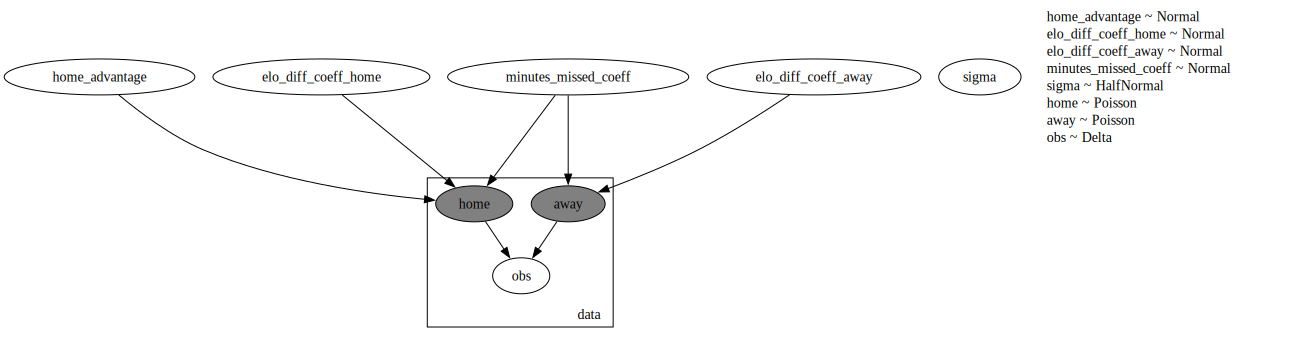

In [70]:
import math

def model(is_home, elo_diff, minutes_missed, goal_home = None, goal_away = None):
    home_advantage = pyro.sample("home_advantage", dist.Normal(0.3, 1.))
    elo_diff_coeff_home = pyro.sample("elo_diff_coeff_home", dist.Normal(1., 1.))
    elo_diff_coeff_away = pyro.sample("elo_diff_coeff_away", dist.Normal(1., 1.))
    minutes_missed_coeff = pyro.sample("minutes_missed_coeff", dist.Normal(1., 1.))
    #b_ar = pyro.sample("bAR", dist.Normal(0., 1.))
    sigma = pyro.sample("sigma", dist.HalfNormal(0.1))

    mean_home = ((is_home * home_advantage) + (elo_diff * elo_diff_coeff_home)) * torch.abs(1 - (minutes_missed * minutes_missed_coeff))
    mean_away = (((-1 * elo_diff) * elo_diff_coeff_away)) * torch.abs(1 - (minutes_missed * minutes_missed_coeff))

    mean_home = torch.exp(mean_home)
    mean_away = torch.exp(mean_away)

    with pyro.plate("data", len(mean_home)):
        home = pyro.sample("home", dist.Poisson(mean_home), obs=goal_home)
#with pyro.plate("data", len(mean_away)):
        away = pyro.sample("away", dist.Poisson(mean_away), obs=goal_away)

    # with pyro.plate("data", len(home)):
    #     return pyro.sample("obs", dist.Delta(home - away))
        return pyro.sample("obs", dist.Delta(home - away))

pyro.render_model(model, model_args=(home,
                                     elo_diff, 
                                     minutes_missed, 
                                     goal_home, 
                                     goal_away), render_distributions=True)

In [71]:
auto_guide = pyro.infer.autoguide.AutoNormal(model)
adam = pyro.optim.Adam({"lr": 0.02})
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, auto_guide, adam, elbo)

In [72]:
import matplotlib.pyplot as plt

In [73]:
%%time
pyro.clear_param_store()

# These should be reset each training loop.
auto_guide = pyro.infer.autoguide.AutoNormal(model)
adam = pyro.optim.Adam({"lr": 0.02})  # Consider decreasing learning rate.
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, auto_guide, adam, elbo)

losses = []
for step in range(1000):  # Consider running for more steps.
    loss = svi.step(home, elo_diff, minutes_missed, goal_home, goal_away)
    losses.append(loss)
    if step % 100 == 0:
        print("Elbo loss: {}".format(loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

Elbo loss: inf


/home/morten/.conda/envs/most_pymc/lib/python3.12/site-packages/pyro/poutine/trace_struct.py:280: UserWarning: Encountered NaN: log_prob_sum at site 'home'
  warn_if_nan(
/home/morten/.conda/envs/most_pymc/lib/python3.12/site-packages/pyro/infer/trace_elbo.py:158: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")


ValueError: Expected parameter loc (Parameter of shape ()) of distribution Normal(loc: Parameter containing:
tensor(nan, requires_grad=True), scale: nan) to satisfy the constraint Real(), but found invalid values:
Parameter containing:
tensor(nan, requires_grad=True)
                   Trace Shapes:        
                    Param Sites:        
  AutoNormal.locs.home_advantage        
AutoNormal.scales.home_advantage        
                   Sample Sites:        
                       data dist       |
                           value 69356 |

In [ ]:
predictive = pyro.infer.Predictive(model, guide=auto_guide, num_samples=800)
svi_samples = predictive(home, elo_diff, minutes_missed,  goal_diff=None)
svi_goal_diff = svi_samples["obs"]

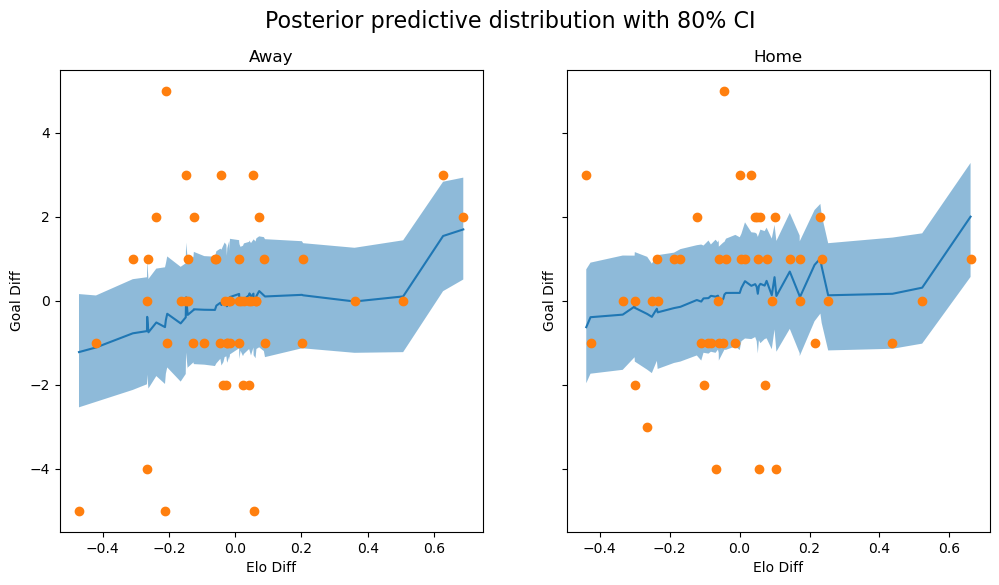

In [26]:
predictions = pd.DataFrame({
    "home": home,
    "elo_diff": elo_diff,
    "minutes_missed": minutes_missed, 
    "y_mean": svi_goal_diff.mean(0).detach().cpu().numpy(),
    "y_perc_5": svi_goal_diff.kthvalue(int(len(svi_goal_diff) * 0.2), dim=0)[0].detach().cpu().numpy(),
    "y_perc_95": svi_goal_diff.kthvalue(int(len(svi_goal_diff) * 0.8), dim=0)[0].detach().cpu().numpy(),
    "goal_diff": goal_diff,
})

predictions = predictions.sample(100)

home_teams = predictions[predictions["home"] == 1].sort_values(by=["elo_diff"])
away_teams = predictions[predictions["home"] == 0].sort_values(by=["elo_diff"])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle("Posterior predictive distribution with 80% CI", fontsize=16)

ax[0].plot(away_teams["elo_diff"], away_teams["y_mean"])
ax[0].fill_between(away_teams["elo_diff"], away_teams["y_perc_5"], away_teams["y_perc_95"], alpha=0.5)
ax[0].plot(away_teams["elo_diff"], away_teams["goal_diff"], "o")
ax[0].set(xlabel="Elo Diff", ylabel="Goal Diff", title="Away")

ax[1].plot(home_teams["elo_diff"], home_teams["y_mean"])
ax[1].fill_between(home_teams["elo_diff"], home_teams["y_perc_5"], home_teams["y_perc_95"], alpha=0.5)
ax[1].plot(home_teams["elo_diff"], home_teams["goal_diff"], "o")
ax[1].set(xlabel="Elo Diff", ylabel="Goal Diff", title="Home");

In [18]:
# (is_home * home_advantage) + (elo_diff * elo_diff_coeff) - (minutes_missed * minutes_missed_coeff))
home_test = 0
elo_diff_test = 70 / elo_std
minutes_missed_test = 45 / minutes_missed_std

(home_test * trace.posterior.home_advantage.values[0][0] + elo_diff_test * trace.posterior.elo_diff_coeff.values[0][0]) * abs(1 -  minutes_missed_test * trace.posterior.minutes_missed_coeff.values[0][0])

0.3811707658117415

In [19]:
trace.to_netcdf("/home/morten/Develop/packing-report/metrics/mov_elo/mov_elo.nc")

'/home/morten/Develop/packing-report/metrics/mov_elo/mov_elo.nc'